User friendly features include:
* easy to fetch TFOP parameters
* handles any number of bands
* easy to switch between models
  - achromatic & chromatic
  - specifying covariates (default=Airmass)
  - linear model polynomial order (default=1)
* shows useful plots: quicklook, raw data, posteriors, FOV, etc

Note:
* To re-define the priors, manually edit `get_chi2_chromatic_transit` method within `LPF` class

In [1]:
import sys
sys.path.insert(0, '/ut3/muscat/reduction_afphot/notebooks/TFOP')
from tfop_analysis import Star, Planet, LPF

/ut3/muscat/reduction_afphot/notebooks/TFOP/tfop_analysis.py:47: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Get TFOP parameters for the host star

In [ ]:
target = 'TOI-6449'
star = Star(target, source='tic')
star_params = star.params_to_dict()
star_params

Mstar=(0.45,0.02) Msun
Rstar=(0.45,0.02) Rsun
Rhostar=(4.81,0.55) rhosun
teff=(3356,157) K
logg=(4.78,0.01) cgs
feh=(0.00,0.10) dex


{'rstar': (0.454183, 0.0155273),
 'mstar': (0.454183, 0.0155273),
 'rhostar': (4.813903712185822, 0.5460704755765515),
 'teff': (3356.0, 157.0),
 'logg': (4.7778, 0.008642),
 'feh': (0.0, 0.1)}

## Get TFOP parameters for the planet candidate

In [3]:
planet = Planet(target, alias='b', star_params=star_params, source='toi')
planet_params = planet.params_to_dict()
planet_params

t0=(2459984.192328, 0.0018611) BJD
P=(2.4404127, 0.000413) d
Rp/Rs=[0.25979992 0.07893168]


{'t0': (2459984.192328, 0.0018611),
 'period': (2.4404127, 0.000413),
 'tdur': array([0.     , 0.00825]),
 'imp': (0.0, 0.1),
 'rprs': array([0.25979992, 0.07893168]),
 'a_Rs': (12.879247193048114, 0.48699053548942756)}

In [4]:
#timings from TTF
ing = 10338.018+2450000
mid = 10338.0465+2450000
egr = 10338.0746+2450000

In [5]:
planet_params['t0'] = (mid, 3/60/24)
planet_params['tdur'] = (81/60/24, 12/60/24)

In [6]:
#where's the photometry data?
!ls /ut3/muscat/reduction_afphot/notebooks/TFOP/muscat4/$target/*.csv

zsh:1: no matches found: /ut3/muscat/reduction_afphot/notebooks/TFOP/muscat4/TOI-6449/*.csv


## get photometry data into a dict={'band': 'dataframe'}


In [7]:
from pathlib import Path
import pandas as pd

def read_phot_data(phot_dir, date, bands=['g','r','i','z']):
    data = {}
    phot_files = list(Path(phot_dir).glob(f'*{date}*.csv'))
    errmsg = f"No photometry files found in {phot_dir}"
    assert len(phot_files)>0, errmsg
    
    for fp in phot_files:
        band = fp.name.split('_')[2]
        if band in bands:
            data[band] = pd.read_csv(fp)
    return data

In [9]:
phot_dir = f'/ut3/muscat/reduction_afphot/notebooks/TFOP/muscat4/{target}/tfop'
date = '240128'
data = read_phot_data(phot_dir, date)
data.keys()

dict_keys(['i', 'z', 'r', 'g'])

## Quick look

In [ ]:
import sys

sys.path.insert(0, "/raid_ut3/home/muscat/reduction/sinistro/")

from sinistro_functions import plot_ql

In [ ]:
from tfop_analysis import colors
from pathlib import Path
import pandas as pd
from aesthetic.plot import savefig

inst = 'muscat4'
exptimes = {'g':90, 'r':60, 'i': 30, 'z':29}
for i,b in enumerate(data):
    fig = plot_ql(data[b],
                  date,
                  target=target,
                  planet='.01',
                  exptime=exptimes[b],
                  band=b,
                  mcolor=colors[b],
                  site='Siding Spring',
                  tel='LCO-2m',
                  inst='MuSCAT4',
                  rms_bintime_mins=10
                 )
    if False:
        outfile = f"{target}.01_{date}_{inst}_{b}_ql.pdf"
        savefig(fig, outfile, dpi=300, writepdf=False)

## Transit fit

In [10]:
#The number of bands supplied is automatically taken into account in modeling
lpf = LPF(name=target,
          ticid=star.ticid,
          data=data,
          inst='MuSCAT4',
          date=date,
          alias='.01',
          # bands=['r','i','z'], #limit the bands
          model='chromatic', 
          star_params=star_params, 
          planet_params=planet_params, 
          time_offset=2460338,
          covariate='Airmass',
          lm_order=1,
          # mask_start=2460232.8,
          # mask_end=2460233.1
          use_r1r2=False,
          DEBUG=False
         )
lpf

LPF(name='TOI-6449', ticid='168936945', date='240128', inst='MuSCAT4', alias='.01', bands=['g', 'r', 'i', 'z'], model='chromatic', time_offset=2460338, covariate='Airmass', lm_order=1, mask_start=None, mask_end=None, use_r1r2=False)

In [16]:
lpf.model_params

{'tc': (0.046500000171363354, 0.0020833333333333333),
 'a_Rs': (12.879247193048114, 0.48699053548942756),
 'imp': (0.0, 0.1),
 'k_g': array([0.25979992, 0.07893168]),
 'k_r': array([0.25979992, 0.07893168]),
 'k_i': array([0.25979992, 0.07893168]),
 'k_z': array([0.25979992, 0.07893168]),
 'd_g': (0, 0),
 'd_r': (0, 0),
 'd_i': (0, 0),
 'd_z': (0, 0)}

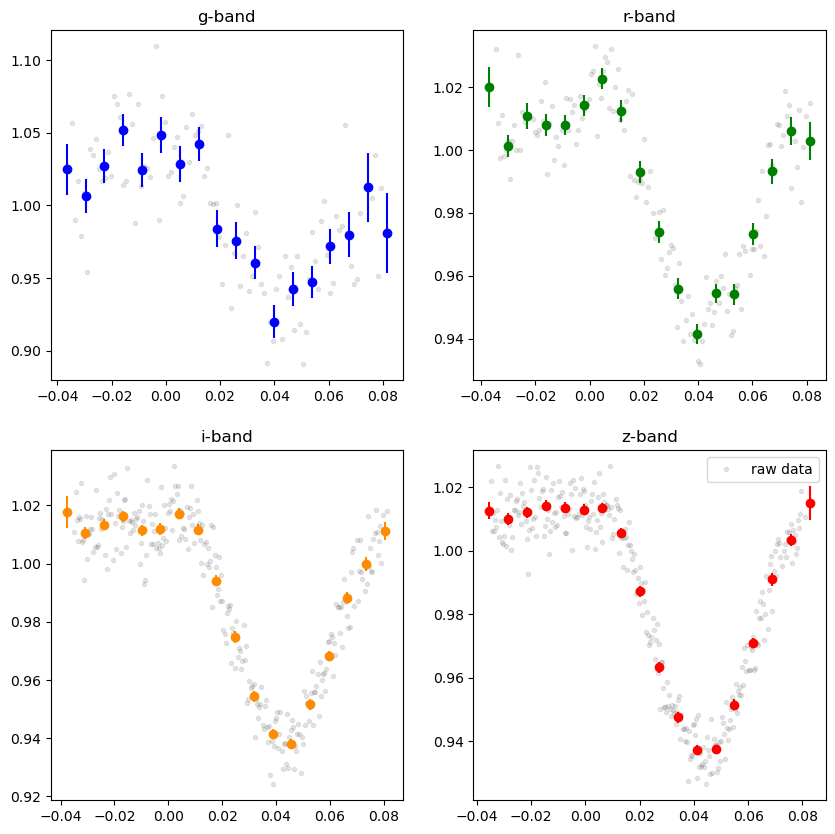

In [14]:
fig = lpf.plot_raw_data()

In [15]:
lpf.optimize_chi2_linear_baseline()

6048.90623319328 True [0.02440646 0.02069432 0.01792768 0.01656962]


In [16]:
p0 = [v[0] for k,v in lpf.model_params.items()]
p0

[0.046500000171363354,
 12.879247193048114,
 0.0,
 0.2597999230176945,
 0.2597999230176945,
 0.2597999230176945,
 0.2597999230176945,
 0,
 0,
 0,
 0]

In [17]:
lpf.get_chi2_chromatic_transit(p0)

1809.1168923769035

## Optimization

In [18]:
while True:
    lpf.optimize_chromatic_transit(p0)
    if lpf.opt_result.success:
        break

Caution: Optimization **NOT** successful!
Caution: Optimization **NOT** successful!
Caution: Optimization **NOT** successful!
Optimization successful!
---------------------
Optimized parameters:
tc: 0.04
a_Rs: 11.68
imp: 1.10
k_g: 0.57
k_r: 0.51
k_i: 0.50
k_z: 0.50
d_g: -1.06
d_r: -0.28
d_i: -0.16
d_z: -0.21


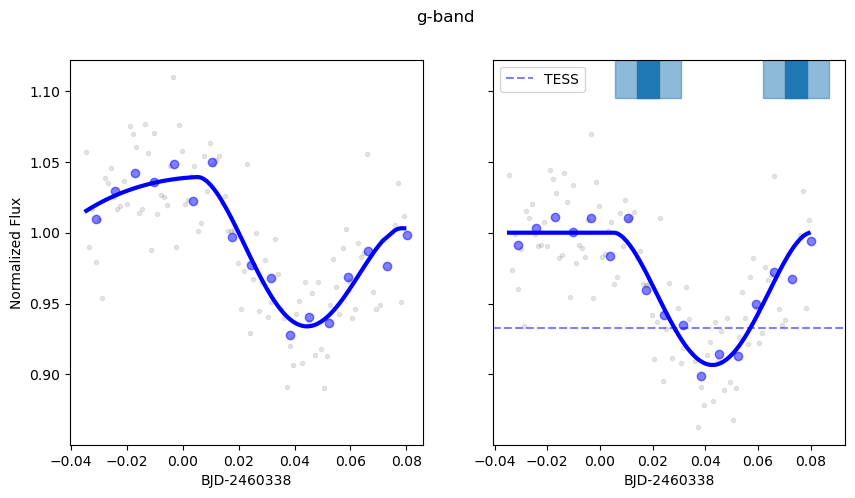

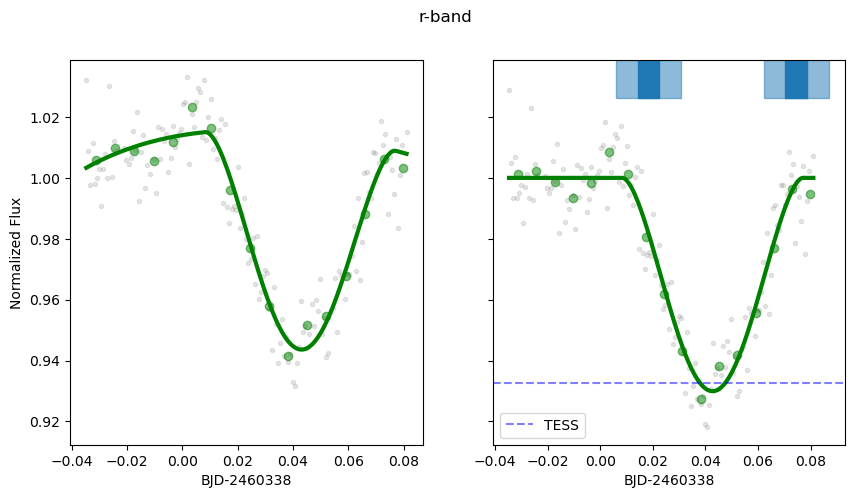

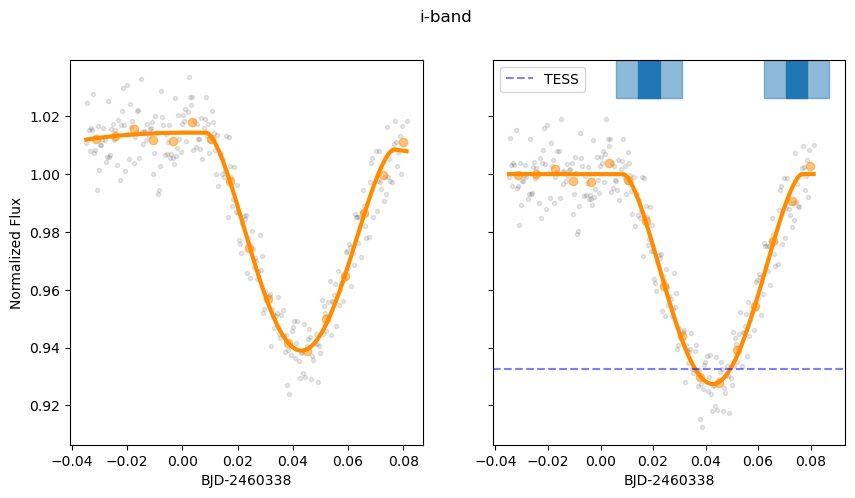

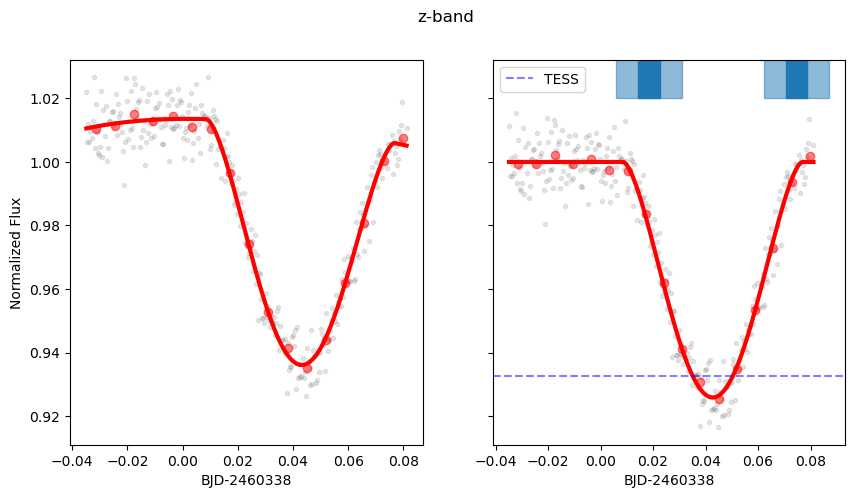

In [19]:
# using optimized parameters
pv = lpf.optimum_params
fig = lpf.plot_lightcurves(pv, figsize=(10,5))

## MCMC

In [20]:
lpf.sample_mcmc(nsteps=3_000)

100%|██████████| 3000/3000 [04:38<00:00, 10.79it/s]


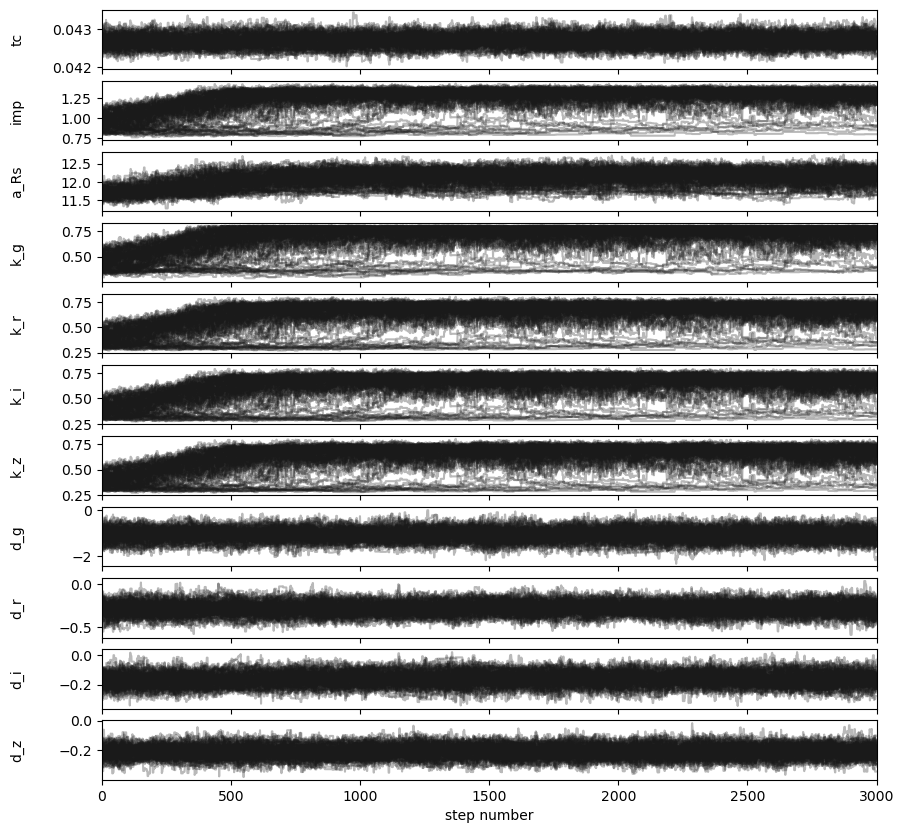

In [21]:
fig = lpf.plot_chain()

## Posteriors

In [114]:
df = lpf.get_mcmc_samples()
df.head()

if False:
    outfile = f'{lpf.model}_samples.csv.gz'
    df.to_csv(outfile, index=False)
    print("Saved: ", outfile)

tc       imp       a_Rs       k_g       k_r       k_i       k_z  \
0  2.460338e+06  1.054062  11.790687  0.529359  0.462538  0.459028  0.458582   
1  2.460338e+06  1.019685  11.541367  0.549493  0.426812  0.432454  0.432251   
2  2.460338e+06  1.240335  11.971846  0.668027  0.622244  0.614404  0.614628   
3  2.460338e+06  1.000461  11.428903  0.484255  0.431700  0.421555  0.426518   
4  2.460338e+06  1.284848  12.139342  0.747648  0.661499  0.662467  0.657545   

        d_g       d_r       d_i       d_z  
0 -0.649333 -0.273759 -0.196603 -0.122449  
1 -0.898566 -0.247324 -0.131347 -0.195260  
2 -1.446915 -0.303741 -0.212508 -0.153231  
3 -1.168408 -0.303468 -0.111181 -0.190986  
4 -1.094139 -0.235187 -0.235048 -0.240477

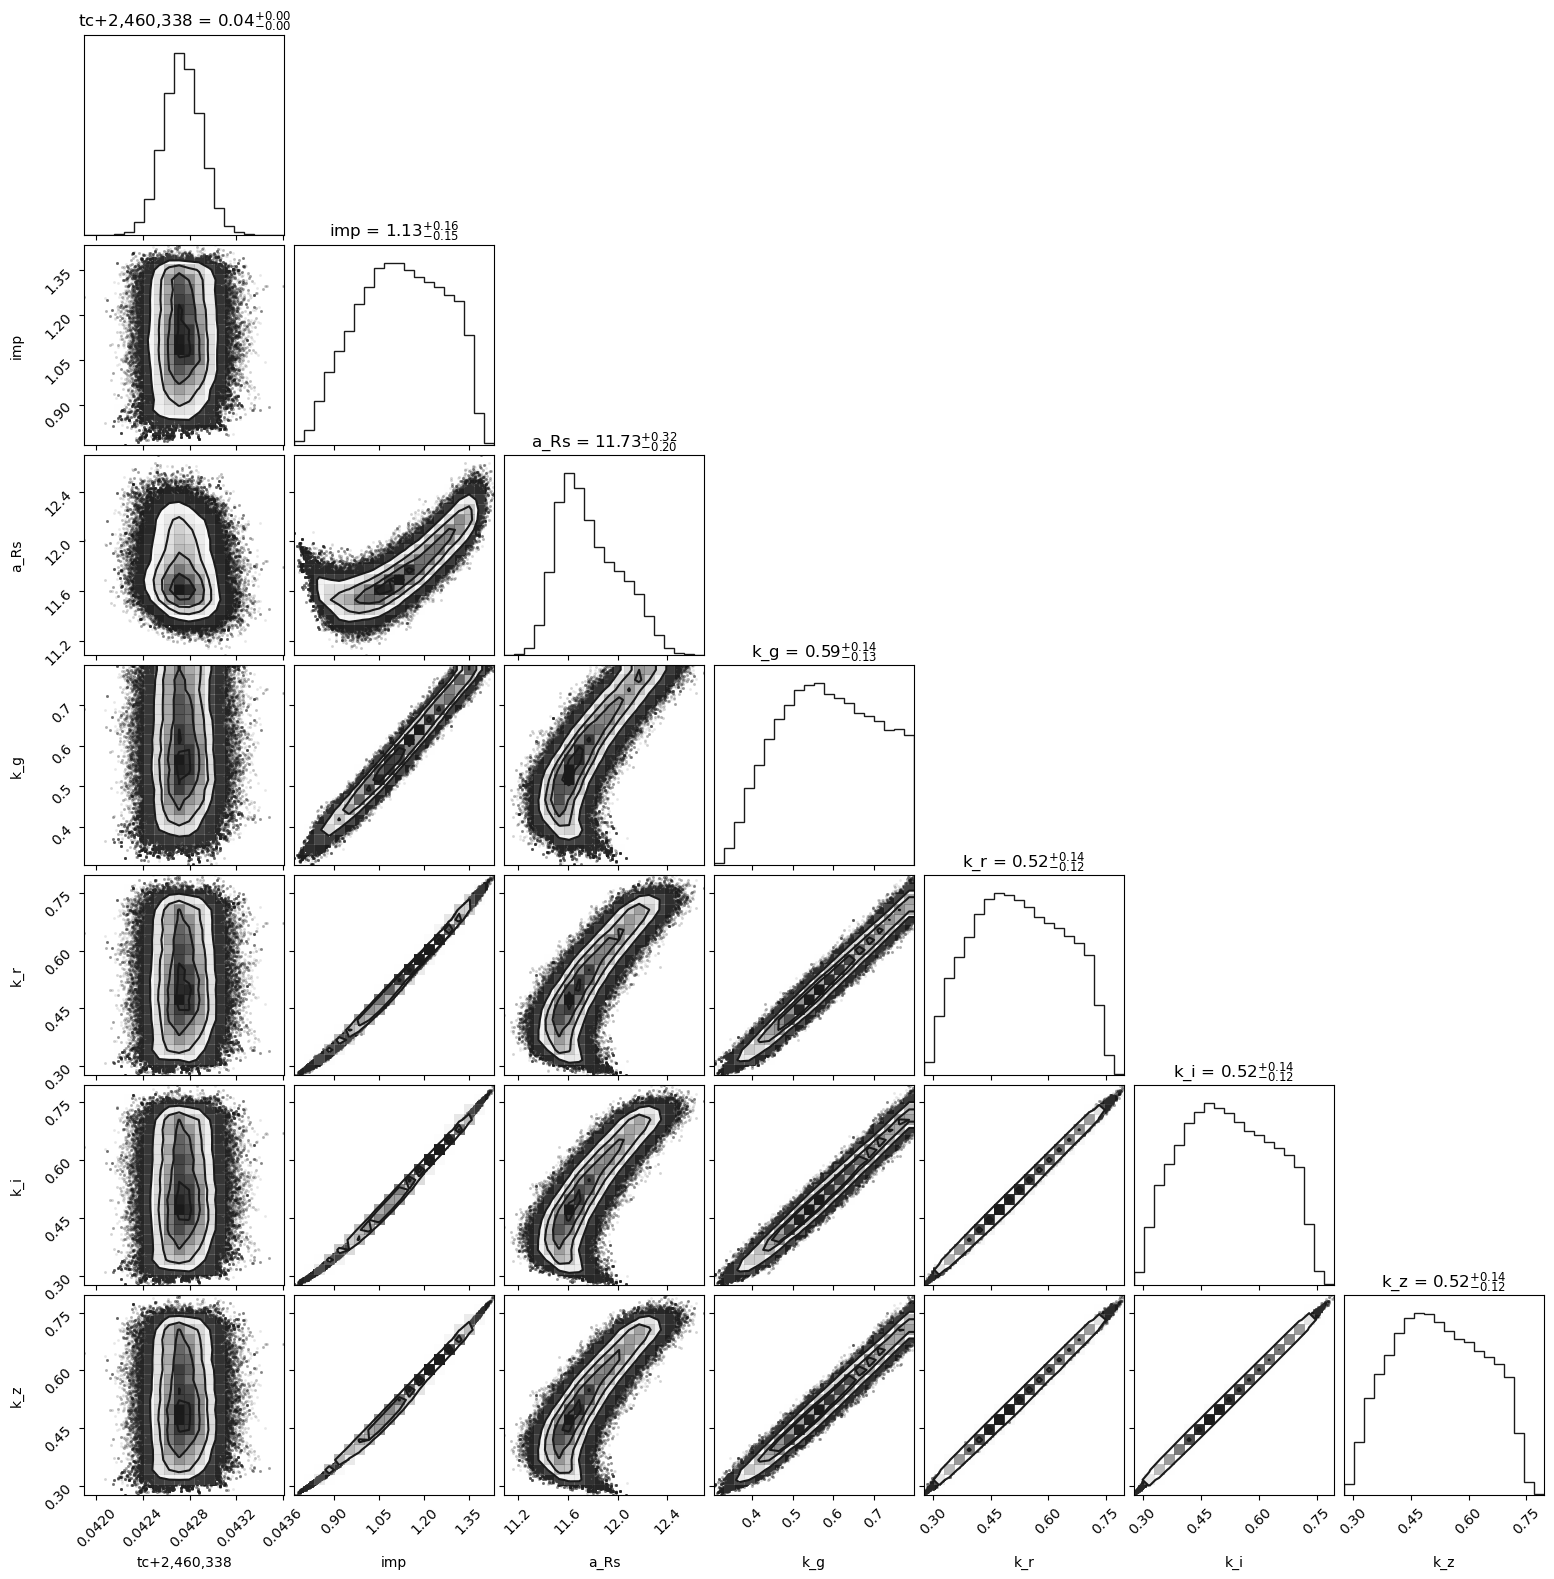

In [116]:
from aesthetic.plot import savefig

fig = lpf.plot_corner(discard=1, thin=10, start=0, end=7)

if False:
    outfile = f"{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_corner.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)    

Rp/Rs(g)^2 = 345.33 ppt
Rp/Rs(r)^2 = 273.28 ppt
Rp/Rs(i)^2 = 269.69 ppt
Rp/Rs(z)^2 = 270.49 ppt


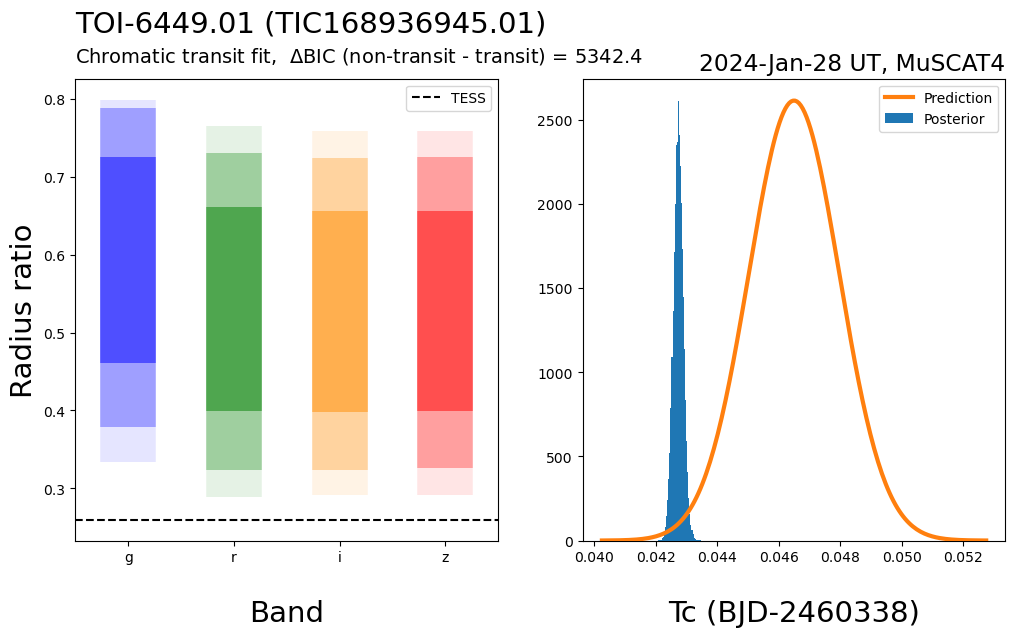

In [150]:
from aesthetic.plot import savefig

fig = lpf.plot_posteriors(nsigma=3)

if False:
    outfile = f"{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_posteriors.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

## Final fit

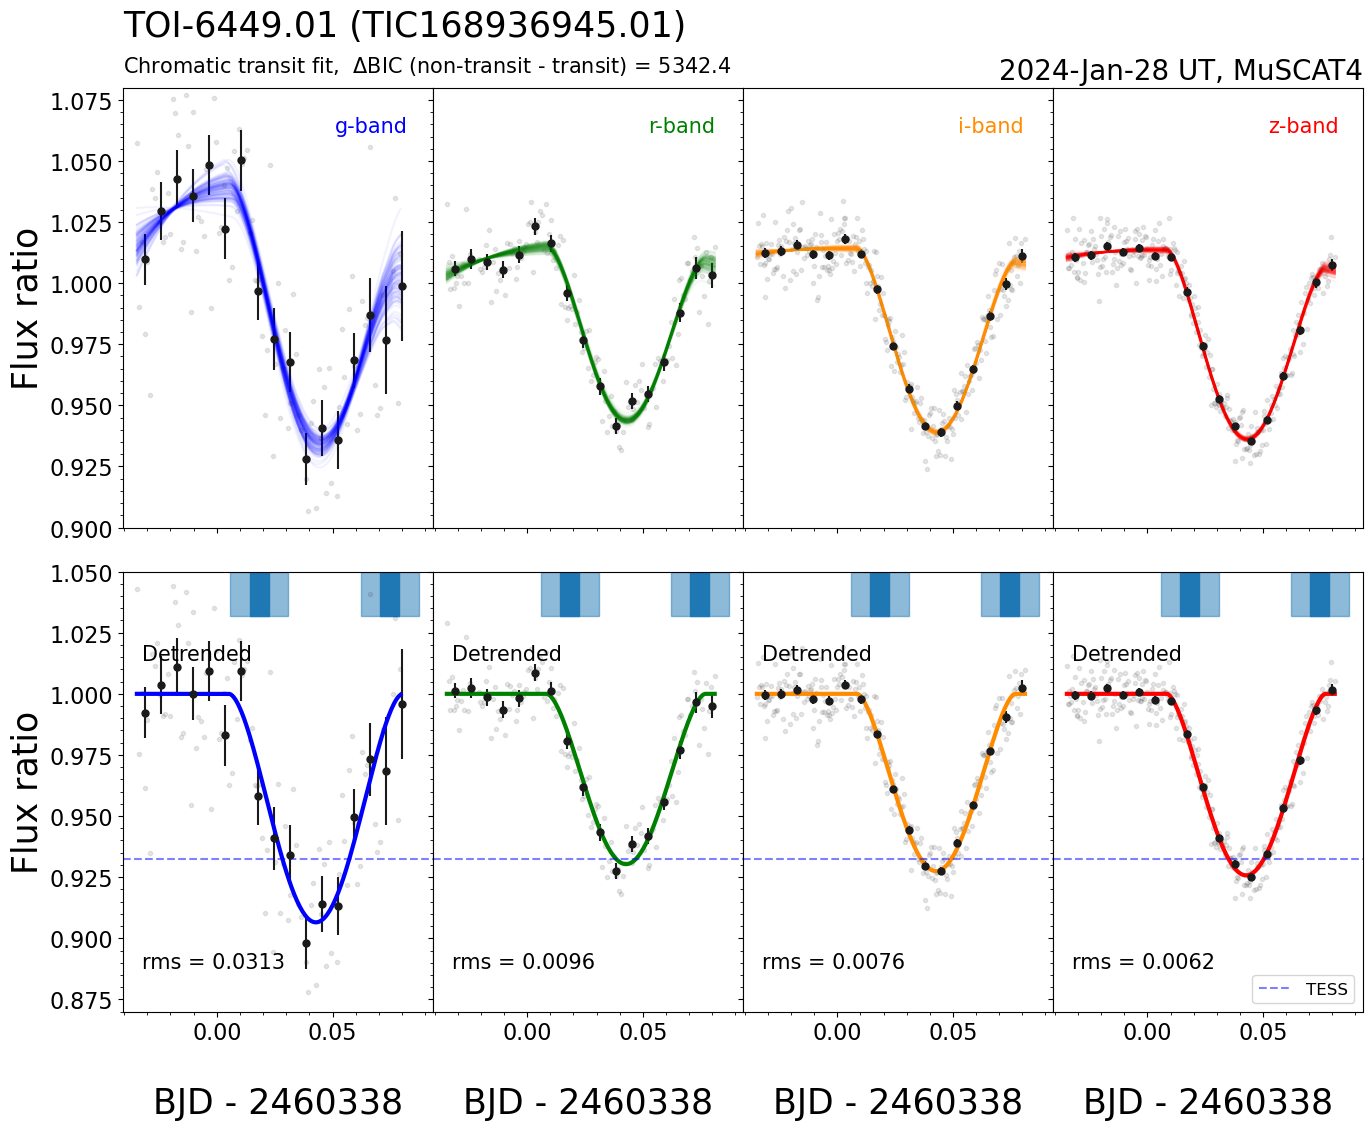

In [152]:
from aesthetic.plot import savefig

fig = lpf.plot_final_fit(ylims_top=(0.9,1.08),
                         ylims_bottom=(0.87,1.05), 
                         fsize=25)

if False:
    outfile = f"{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_transit_fit.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

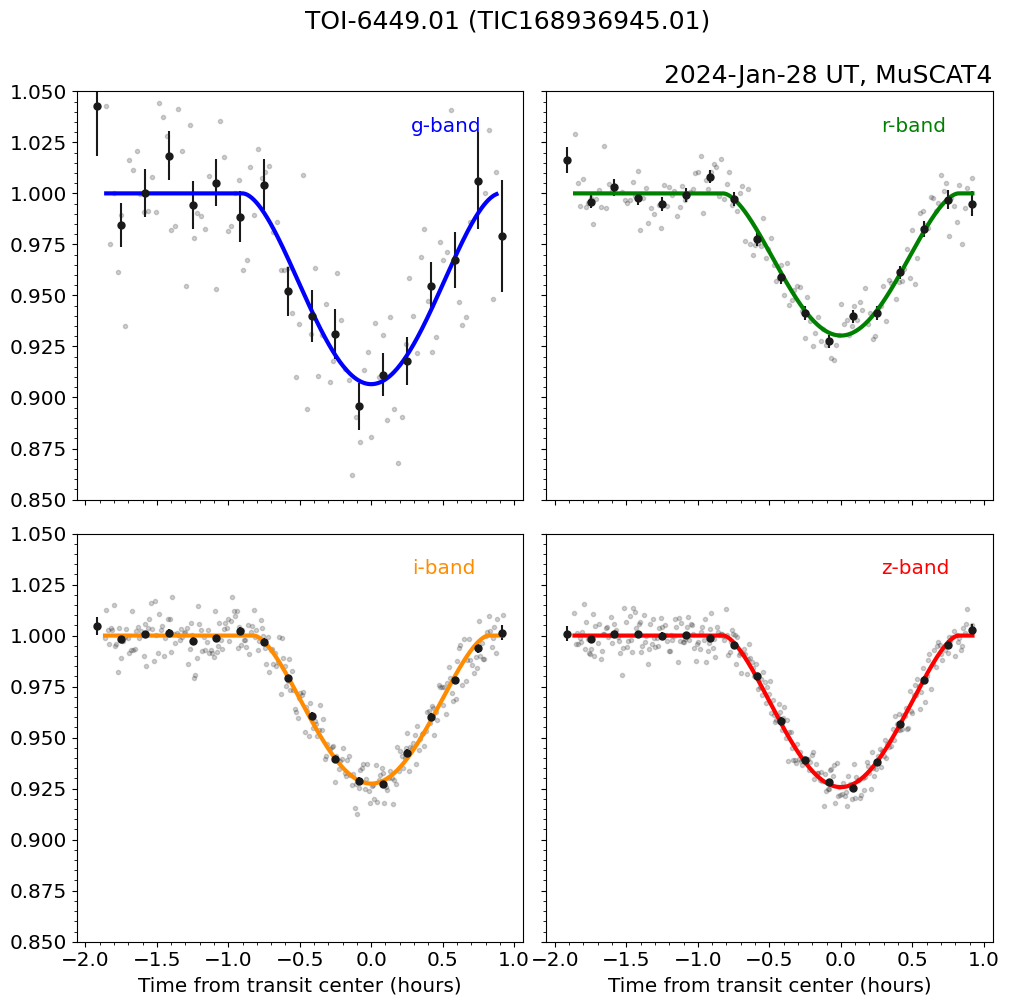

In [154]:
from aesthetic.plot import savefig

pv = lpf.best_fit_params
fig = lpf.plot_detrended_data_and_transit(pv, figsize=(10,10), 
                                          # xlims=(-1.3,1.3),
                                          ylims=(0.85, 1.05),
                                          title_height=1,
                                          fsize=18
                                         )
if False:
    outfile = f"{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_transit_models.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

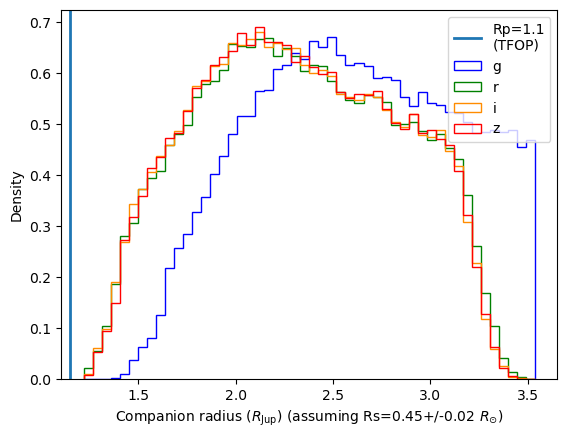

In [140]:
import astropy.units as u
from tfop_analysis import colors

rstar = lpf.star_params['rstar'][0]

if lpf.model=='chromatic':
    cols = [f'k_{b}' for b in lpf.bands]
    d = df[cols].apply(lambda x: x*rstar*u.Rsun.to(u.Rjup))
    d.columns = lpf.bands
else:
    d = df['k'].apply(lambda x: x*rstar*u.Rsun.to(u.Rjup))
    d.name = 'achromatic Rp'
ax = d.plot.hist(grid=False, bins=50, histtype='step', stacked=False, density=True, color=colors.values())
ax.set_xlabel(r"Companion radius ($R_{\rm{Jup}}$)"+f" (assuming Rs={star.rstar[0]:.2f}+/-{star.rstar[1]:.2f}"+r" $R_{\odot}$)")
Rp_tfop = lpf.planet_params['rprs'][0]*rstar*u.Rsun.to(u.Rjup)
ax.axvline(Rp_tfop, 0, 1, lw=2, label=f'Rp={Rp_tfop:.1f}\n(TFOP)')
ax.set_ylabel('Density')
ax.legend()

fig = ax.figure
if False:
    outfile = f"{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_radii.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

## FOV

In [13]:
ls /ut3/muscat/reduction_afphot/muscat4/$date/$target/reference

ref-coj2m002-ep07-20240128-0077-e91.fits
ref-coj2m002-ep07-20240128-0077-e91.objects
ref-coj2m002-ep09-20240128-0075-e91.fits
ref-coj2m002-ep09-20240128-0075-e91.objects


In [16]:
!cat $ref_obj_file_path

# ./df/coj2m002-ep09-20240128-0075-e91.fits 2048 2048
# dark = 0
# median sky = 425.707
# noise = 23.8685
# threshold  = 10
# hmin  = 238.685
# ADU range -1000 130000
# apradius = 20
# apADUmin = 10000
# apPixmin = 10
# Subframe 200 1800 200 1800
# Find on 200 1800 200 1800
       1     1707.566      271.064     1708.000      271.000  6687771.000    39668.180
       2     1107.797      584.667     1108.000      584.000  4351893.000    26934.875
       3      860.501     1454.891      859.000     1456.000   339349.125     2296.255
       4     1590.084      925.721     1591.000      926.000   247444.062     1896.390
       5      499.205      220.528      499.000      220.000   246679.516     1921.211
       6     1475.268     1183.031     1477.000     1184.000   204474.906     1649.996
       7      799.463      495.555      801.000      496.000   196440.688     1621.520
       8     1379.426      539.617     1379.000      541.000   179110.203     1548.519
       9     1575.739      85

In [33]:
from aesthetic.plot import savefig

ra, dec = star.ra, star.dec
afphot_dir = f'/ut3/muscat/reduction_afphot/muscat4/{date}/{target}'
ref_fits_file_path = f'{afphot_dir}/reference/ref-coj2m002-ep09-20240128-0075-e91.fits'
ref_obj_file_path = f'{afphot_dir}/reference/ref-coj2m002-ep09-20240128-0075-e91.objects'

fig = lpf.plot_fov(ra, dec, 
                   ref_fits_file_path, ref_obj_file_path,
                   phot_aper_pix=30,
                   cmap='gray',
                   contrast=0.1,
                   marker_color='g',
                   text_offset=(0.005, -0.007),
                   scale_color='w',
                   font_size=20,
                   title_height=0.99,
                   show_target=True
                  )
if True:
    outfile = f"{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_z_FOV.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

2024-02-01T04:05:56.633669: made TOI-6449.01_20240128_MuSCAT4_z_FOV.pdf


In [34]:
from aesthetic.plot import savefig

fig = lpf.plot_fov_zoom(ra, dec, 
                        ref_fits_file_path, 
                        ref_obj_file_path,
                        zoom_rad_arcsec=60,
                        bar_arcsec=30,
                        phot_aper_pix=16,
                        cmap='gray',
                        contrast=0.1,
                        marker_color='g',
                        text_offset=(-0.001, -0.002),
                        scale_color='w',
                        font_size=20,
                        title_height=0.99,
                  )
if True:
    outfile = f"{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_z_FOV_zoom.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

2024-02-01T04:06:01.505644: made TOI-6449.01_20240128_MuSCAT4_z_FOV_zoom.pdf


## Compare to Gaia

In [24]:
gaia_sources = star.get_gaia_sources(rad_arcsec=60)
gaia_sources.tail()

Querying Gaia sources 60" around TOI-6449: (125.9305, -5.1895) deg.


solution_id                   designation            source_id  \
5  1635721458409799680  Gaia DR2 3065970448725166592  3065970448725166592   
6  1635721458409799680  Gaia DR2 3065970306992482304  3065970306992482304   
7  1635721458409799680  Gaia DR2 3065970341350172160  3065970341350172160   
8  1635721458409799680  Gaia DR2 3065970306990616704  3065970306990616704   
9  1635721458409799680  Gaia DR2 3065970306990648832  3065970306990648832   

  random_index  ref_epoch          ra   ra_error       dec  dec_error  \
5   1229802523     2015.5  125.943584   0.046124 -5.188518   0.035130   
6   1420012143     2015.5  125.919668   6.826816 -5.198015   4.014375   
7   1655416117     2015.5  125.944783   0.202826 -5.191909   0.156519   
8    362959562     2015.5  125.930888  10.120919 -5.205093  15.193645   
9   1545302146     2015.5  125.917792   0.756717 -5.199268   0.582386   

   parallax  ...  e_bp_min_rp_percentile_lower  e_bp_min_rp_percentile_upper  \
5  0.890090  ...                        0.0052                        0.0616   
6       NaN  ...                           NaN                           NaN   
7  0.134663  ...                           NaN                           NaN   
8       NaN  ...                           NaN                           NaN   
9 -0.766882  ...                           NaN                           NaN   

   flame_flags  radius_val  radius_percentile_lower  radius_percentile_upper  \
5       200111    0.729568                 0.612295                 0.832648   
6          NaN         NaN                      NaN                      NaN   
7          NaN         NaN                      NaN                      NaN   
8          NaN         NaN                      NaN                      NaN   
9          NaN         NaN                      NaN                      NaN   

    lum_val  lum_percentile_lower  lum_percentile_upper   distance  
5  0.561501              0.484217              0.638786  47.199900  
6       NaN                   NaN                   NaN  49.361581  
7       NaN                   NaN                   NaN  52.097472  
8       NaN                   NaN                   NaN  56.171948  
9       NaN                   NaN                   NaN  57.435948  

[5 rows x 95 columns]

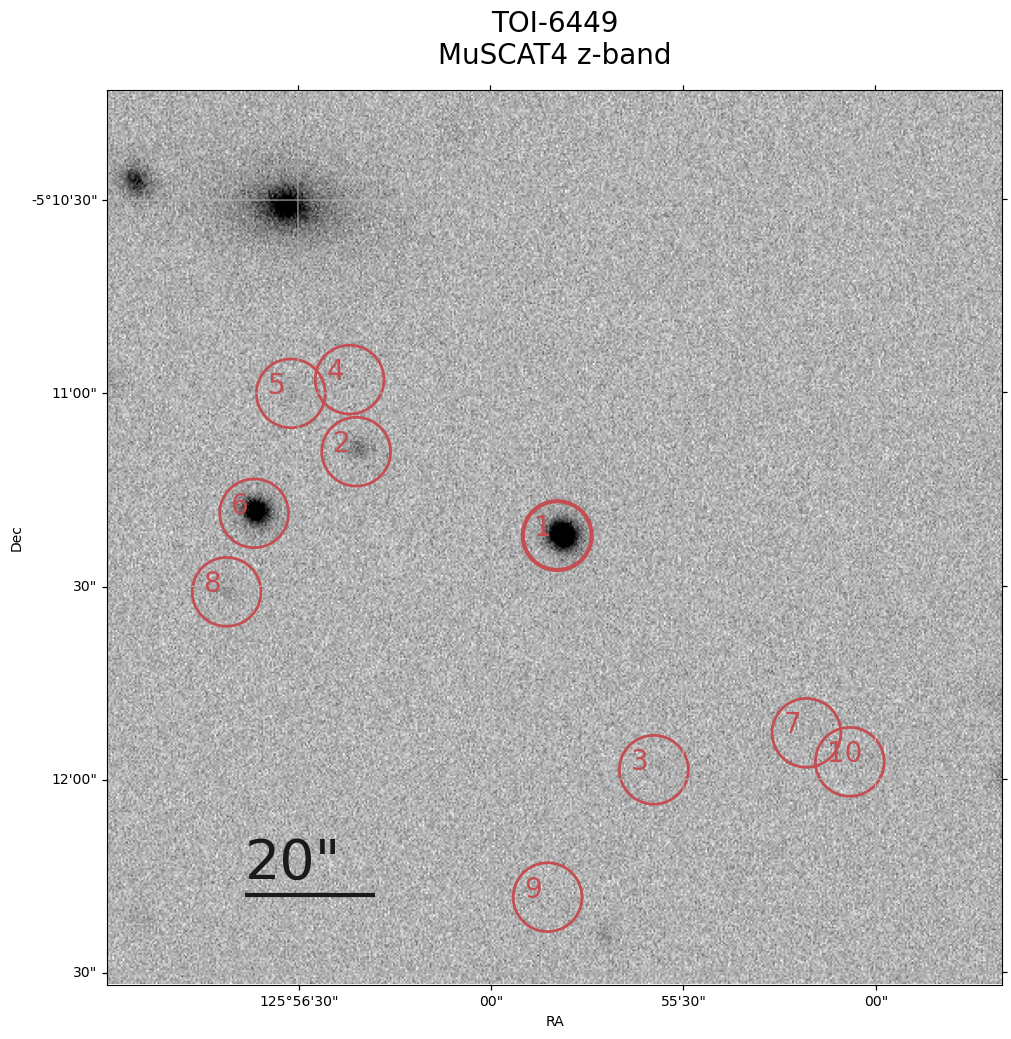

In [29]:
from aesthetic.plot import savefig

afphot_dir = f'/ut3/muscat/reduction_afphot/muscat4/{date}/{target}'
fits_file_path = f'{afphot_dir}/reference/ref-coj2m002-ep09-20240128-0075-e91.fits'

fig = lpf.plot_gaia_sources(fits_file_path, 
                            gaia_sources, 
                            phot_aper_pix=20,
                            text_offset=(0.001, 0),
                            fov_padding=1.2,
                            cmap='gray_r',
                            contrast=0.1,
                            bar_arcsec=20,
                            marker_color='r',
                            scale_color='k',
                            font_size=20,
                            title_height=0.99,
                           )
if False:
    outfile = f"{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_r_FOV_gaia_sources.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

In [11]:
import pandas as pd
from corner import corner

df1 = pd.read_csv('muscat4/TOI-6449/tfop/chromatic_samples.csv.gz')
df2 = pd.read_csv('muscat4/TOI-6449/tfop_transform/chromatic_samples_transform.csv.gz')

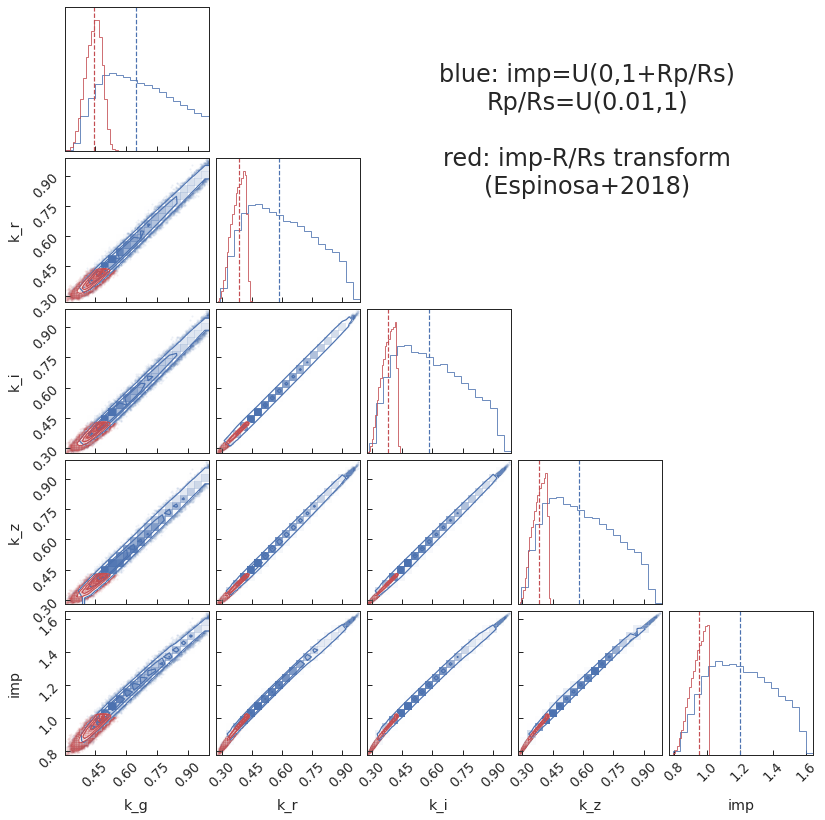

In [69]:
import numpy as np

cols = ['k_g','k_r','k_i','k_z','imp']
fig = corner(df1[cols], color='b', show_titles=False, quantiles=[0.5])
_ = corner(df2[cols], fig=fig, weights=np.ones(len(df2))*len(df1)/len(df2), quantiles=[0.5], color='r')
fig.suptitle(f"blue: imp=U(0,1+Rp/Rs)\nRp/Rs=U(0.01,1)\n\nred: imp-R/Rs transform\n(Espinosa+2018)", 
             y=0.9, x=0.7, fontsize=24);